In [1]:
%load_ext autoreload
%autoreload 2
import twint
import nest_asyncio
nest_asyncio.apply()
import pandas as pd 
pd.set_option('display.max_columns', None)
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [2]:
locations = {'SW':'50.540176,-3.401552,128.61612km',
            'SE':'51.219442,0.007482,110.97009km',
            'Wales':'52.308407,-4.184044,103.89385km',
            'E':'52.505440,0.935452,70.29115km',
            'Mid':'52.584523,-1.284716,61.4968km',
            'NW':'53.688576,-2.467244 ,92.91998km',
            'NE':'55.092211,-1.272652,78.99957km',
            'Scotland':'56.391056,-4.206108,169.73168km'}

In [3]:
import pandas as pd

In [111]:
df = pd.read_csv('test.csv')

In [5]:
reverse_locations = {}
for i in locations.items():
    reverse_locations[i[1]] = i[0]
reverse_locations

{'50.540176,-3.401552,128.61612km': 'SW',
 '51.219442,0.007482,110.97009km': 'SE',
 '52.308407,-4.184044,103.89385km': 'Wales',
 '52.505440,0.935452,70.29115km': 'E',
 '52.584523,-1.284716,61.4968km': 'Mid',
 '53.688576,-2.467244 ,92.91998km': 'NW',
 '55.092211,-1.272652,78.99957km': 'NE',
 '56.391056,-4.206108,169.73168km': 'Scotland'}

### Reverse mapping of locations

In [112]:
df['geo'] = df.geo.map(reverse_locations)

### Dropping null columns

In [113]:
df = df.dropna(axis=1)

### Keeping only english tweets

In [114]:
df = df[df.language == 'en']

### Drop remaining columns

In [115]:
#dropped because they are not unique, for privacy, can't process or are not relevant
columns_drop = ['timezone','username','name','urls','photos','cashtags','link','retweet','video','reply_to', 'mentions']

In [116]:
df = df.drop(columns=columns_drop)

### Add figure searched for

In [117]:
df['figure'] = 'matthancock'

In [118]:
df.head(2)

,id,conversation_id,created_at,date,time,user_id,tweet,language,replies_count,retweets_count,likes_count,hashtags,figure
0,1403375621342908416,1403117579057643526,2021-06-11 16:36:36 BST,2021-06-11,16:36:36,2518781326,@WelshDalaiLama @MattHancock back in your box ...,en,0,0,0,[],matthancock
1,1403372248149499904,1402923308362960896,2021-06-11 16:23:12 BST,2021-06-11,16:23:12,148712066,@marky_edwards @AllisonPearson @Iromg @MattHan...,en,0,0,0,[],matthancock


## Import models

In [11]:
import joblib

In [12]:
model = joblib.load('../le_kingmakers/model2.joblib')

In [90]:
model

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('clean_text', TextPreprocess()),
                                 ('convert_text', TextConvertAbbv())])),
                ('vectorizer', TfidfVectorizer(max_df=0.2, ngram_range=(1, 2))),
                ('model', MultinomialNB())])

In [70]:
test_sample = df['tweet'].sample()
type(test_sample)

pandas.core.series.Series

In [71]:
print(test_sample.values), model.predict(test_sample)

['@lhdimport @BorisJohnson @MattHancock How can’t you buy a suit? Everywheres open']


(None, array([0]))

In [119]:
df['prediction'] = model.predict(df['tweet'])

In [120]:
sentiment_map = {0:-1, 4:1}

In [121]:
df['prediction'] = df['prediction'].map(sentiment_map)

In [123]:
df.prediction.value_counts()

-1    7919
 1    5570
Name: prediction, dtype: int64

In [124]:
test_df = df.groupby(by = 'date').sum('prediction')
test_df

,id,conversation_id,user_id,replies_count,retweets_count,likes_count,prediction
date,,,,,,,
2021-06-04,1.629151e+21,1.626364e+21,5.014634e+20,1121.0,3130.0,9159.0,-197.0
2021-06-05,1.227421e+21,1.226206e+21,3.672029e+20,1361.0,4228.0,11276.0,-102.0
2021-06-06,2.696541e+21,2.694573e+21,7.653694e+20,5733.0,18841.0,55447.0,-460.0
2021-06-07,2.376239e+21,2.373832e+21,6.389583e+20,4095.0,9617.0,43541.0,-325.0
2021-06-08,2.299692e+21,2.298750e+21,6.129865e+20,1733.0,3976.0,13468.0,-234.0
2021-06-09,1.618634e+21,1.617075e+21,4.973307e+20,1258.0,6595.0,23629.0,-160.0
2021-06-10,5.415521e+21,5.413974e+21,1.201411e+21,10329.0,33175.0,128201.0,-624.0
2021-06-11,1.651658e+21,1.650607e+21,4.283404e+20,513.0,2245.0,5937.0,-247.0


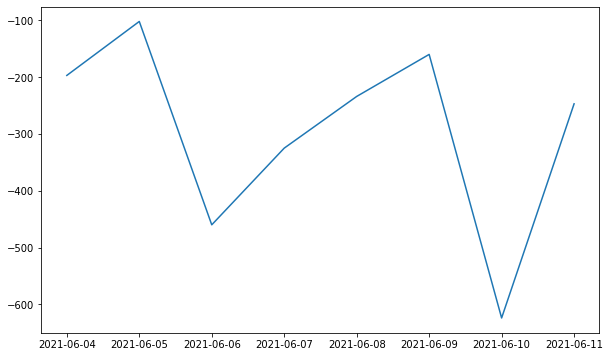

In [127]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index,test_df.prediction)